# Shape Reconstruction

We try two major approaches for 3D shape reconstruction.

Note that training reconstruction methods generally takes relatively long, even for simple shape completion. Training the generalization will take a few hours.

### Install all packages

We can simply install all necessary packages listed in requirements.txt

In [ ]:
!pip install -r requirements.txt

### Imports

The following imports should work regardless of whether we are using Colab or local execution.

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib as plt
import k3d
import trimesh
import torch
import skimage

Use the next cell to test whether a GPU was detected by pytorch.

In [3]:
torch.cuda.is_available()

True

## 3.1 Shape Reconstruction from 3D SDF grids with 3D-EPN

We take a look at shape complation using [3D-EPN](https://arxiv.org/abs/1612.00101).

The visualization below shows an overview of the method: From an incomplete shape observation (which we would get when scanning an object with a depth sensor for example), we use a 3D encoder-predictor network that first encodes the incomplete shapes into a common latent space using several 3D convolution layers and then decodes them again using multiple 3D transpose convolutions.

This way, we get from a 32^3 SDF voxel grid to a 32^3 DF (unsigned) voxel grid that represents the completed shape. We only focus on this part here; in the original implementation, this 32^3 completed prediction would then be further improved (in an offline step after inference) by sampling parts from a shape database to get the final resolution to 128^3.

<img src="src/images/3depn_teaser.png" alt="3D-EPN Teaser" style="width: 800px;"/>

The next steps will follow the structure : Taking a look at the dataset structure and downloading the data; then, implementing dataset, model, and training loop.

###  Downloading the data
We will use the original dataset used in the official implementation. It consists of SDF and DF grids (representing incomplete input data and complete target data) with a resolution of 32^3 each. Each input-target pair is generated from a ShapeNet shape.

The incomplete SDF data are generated by sampling virtual camera trajectories around every object. Each trajectory is assigned an ID which is part of the file names (see below). The camera views for each trajectory are combined into a common SDF grid by volumetric fusion. It is easy to generate an SDF here since we know both camera location and object surface: Everything between camera and surface is known free space and outside the object, leading to a positive SDF sign. Everything behind the surface has a negative sign. For the complete shapes, however, deciding whether a voxel in the DF grid is inside or outside an object is not a trivial problem. This is why we use unsigned distance fields as target and prediction representation instead. This still encodes the distance to the closest surface but does not contain explicit information about the inside/outside location.

In terms of dataset lawet, we follow the ShapeNet directory structure:
Each folder in the `src/data/shapenet_dim32_sdf` and `src/data/shapenet_dim32_df` directories contains one shape category represented by a number, e.g. `02691156`.
We provide the mapping between these numbers and the corresponding names in `src/data/shape_info.json`. Each of these shape category folders contains lots of shapes in sdf or df format. In addition to that, every shape now also contains multiple trajectories: 0 to 7, encoded as `__0__` to `__7__`. These 8 files are just different input representations, meaning they vary in the level of completeness and location of missing parts; they all map to the `.df` file with corresponding shape ID and `__0__` at the end.

```
# contents of src/data/shapenet_dim32_sdf
02691156/                                           # Shape category folder with all its shapes
    ├── 10155655850468db78d106ce0a280f87__0__.sdf   # Trajectory 0 for a shape of the category
    ├── 10155655850468db78d106ce0a280f87__1__.sdf   # Trajectory 1 for the same shape
    ├── :                                      
    ├── 10155655850468db78d106ce0a280f87__7__.sdf   # Trajectory 7 for the same shape
    ├── 10155655850468db78d106ce0a280f87__0__.sdf   # Trajectory 0 for another shape
    ├── :                                           # And so on ...
02933112/                                           # Another shape category folder
02958343/                                           # In total we should have 8 shape category folders
:

# contents of src/data/shapenet_dim32_df
02691156/                                           # Shape category folder with all its shapes
    ├── 10155655850468db78d106ce0a280f87__0__.df    # A single shape of the category
    ├── 1021a0914a7207aff927ed529ad90a11__0__.df    # Another shape of the category
    ├── :                                           # And so on ...
02933112/                                           # Another shape category folder
02958343/                                           # In total we should have 55 shape category folders
:
```

Download and extract the data with the code cell below.

In [ ]:
print('Downloading ...')
# File sizes: 11GB for shapenet_dim32_sdf.zip (incomplete scans), 4GB for shapenet_dim32_df.zip (target shapes)
#!wget http://kaldir.vc.in.tum.de/adai/CNNComplete/shapenet_dim32_sdf.zip -P src/data
!wget http://kaldir.vc.in.tum.de/adai/CNNComplete/shapenet_dim32_df.zip -P src/data
print('Extracting ...')
!unzip -q src/data/shapenet_dim32_sdf.zip -d src/data
!unzip -q src/data/shapenet_dim32_df.zip -d src/data
!rm src/data/shapenet_dim32_sdf.zip
!rm src/data/shapenet_dim32_df.zip
print('Done.')

### Dataset

The data for SDFs and DFs in `.sdf`/`.df` files are stored in binary form as follows:
```
dimX    #uint64 
dimY    #uint64 
dimZ    #uint64 
data    #(dimX*dimY*dimZ) floats for sdf/df values
```
The SDF values stored per-voxel represent the distance to the closest surface *in voxels*.

In [3]:
from src.data.shapenet import ShapeNet

# Create a dataset with train split
train_dataset = ShapeNet('train')
val_dataset = ShapeNet('val')
overfit_dataset = ShapeNet('overfit')

# Get length, which is a call to __len__ function
print(f'Length of train set: {len(train_dataset)}')  # expected output: 153540
# Get length, which is a call to __len__ function
print(f'Length of val set: {len(val_dataset)}')  # expected output: 32304
# Get length, which is a call to __len__ function
print(f'Length of overfit set: {len(overfit_dataset)}')  # expected output: 64

Length of train set: 153540
Length of val set: 32304
Length of overfit set: 64


###  Model

The model architecture of 3D-EPN is visualized below:

<img src="src/images/3depn.png" alt="3D-EPN Architecture" style="width: 800px;"/>

We simplify the model by omitting the classification part - this will not have a big impact since most of the shape completion performance comes from the 3D encoder-decoder unet.

The model consists of three parts: The encoder, the bottleneck, and the decoder. Encoder and decoder are constructed with the same architecture, just mirrored.

The details of each part are:
- **Encoder**: 4 layers, each one containing a 3D convolution (with kernel size 4, as seen in the visualization), a 3D batch norm (except the very first layer), and a leaky ReLU with a negative slope of 0.2. Our goal is to reduce the spatial dimension from 32x32x32 to 1x1x1 and to get the feature dimension from 2 (absolute values and sign) to `num_features * 8`. We do this by using a stride of 2 and padding of 1 for all convolutions except for the last one where we use a stride of 1 and no padding. The feature channels are increased from 2 to `num_features` in the first layer and then doubled with every subsequent layer.
- **Decoder**: Same architecture as encoder, just mirrored: Going from `num_features * 8 * 2` (the 2 will be explained later) to 1 (the DF values). The spatial dimensions go from 1x1x1 to 32x32x32. Each layer use a 3D Transpose convolution now, together with 3D batch norm and ReLU (no leaky ReLUs anymore). Note that the last layer uses neither Batch Norms nor a ReLU since we do not want to constrain the range of possible values for the prediction.
- **Bottleneck**: This is realized with 2 fully connected layers, each one going from a vector of size 640 (which is `num_features * 8`) to a vector of size 640. Each such layer is followed by a ReLU activation.

Some minor details:
- **Skip connections** allow the decoder to use information from the encoder and also improve gradient flow. We use it here to connect the output of encoder layer 1 to decoder layer 4, the output of encoder layer 2 to decoder layer 3, and so on. This means that the input to a decoder layer is the concatenation of the previous decoder output with the corresponding encoder output, along the feature dimension. Hence, the number of input features for each decoder layer are twice those of the encoder layers, as mentioned above.
- **Log scaling**: We also need to scale the final outputs of the network logarithmically: `out = log(abs(out) + 1)`. This is the same transformation we applied to the target shapes in the dataloader before and ensures that prediction and target volumes are comparable.

In [7]:
from src.model.threedepn import ThreeDEPN
from src.util.model import summarize_model

threedepn = ThreeDEPN()
print(summarize_model(threedepn))  # Expected: Rows 0-34 and TOTAL = 52455681

sdf = torch.randn(4, 1, 32, 32, 32) * 2. - 1.
input_tensor = torch.cat([torch.abs(sdf), torch.sign(sdf)], dim=1)
predictions = threedepn(input_tensor)

print('Output tensor shape: ', predictions.shape)  # Expected: torch.Size([4, 32, 32, 32])

   | Name         | Type            | Params  
----------------------------------------------------
0  | e1           | Conv3d          | 10320   
1  | e2           | Conv3d          | 819360  
2  | ebn2         | BatchNorm3d     | 320     
3  | e3           | Conv3d          | 3277120 
4  | ebn3         | BatchNorm3d     | 640     
5  | e4           | Conv3d          | 13107840
6  | ebn4         | BatchNorm3d     | 1280    
7  | bottleneck   | Sequential      | 820480  
8  | bottleneck.0 | Linear          | 410240  
9  | bottleneck.1 | ReLU            | 0       
10 | bottleneck.2 | Linear          | 410240  
11 | bottleneck.3 | ReLU            | 0       
12 | d4           | ConvTranspose3d | 26214720
13 | dbn4         | BatchNorm3d     | 640     
14 | d3           | ConvTranspose3d | 6553760 
15 | dbn3         | BatchNorm3d     | 320     
16 | d2           | ConvTranspose3d | 1638480 
17 | dbn2         | BatchNorm3d     | 160     
18 | d1           | ConvTranspose3d | 10241   
19 | TO

### Training script and overfitting to a single shape reconstruction


In [57]:
from src.training import train_3depn
config = {
    'experiment_name': '3_1_3depn_overfitting',
    'device': 'cuda:0',  # change this to cpu if we do not have a GPU
    'is_overfit': True,
    'batch_size': 32,
    'resume_ckpt': None,
    'learning_rate': 0.001,
    'max_epochs': 200,
    'print_every_n': 10,
    'validate_every_n': 25,
}
train_3depn.main(config)  # should be able to get <0.0025 train_loss and <0.13 val_loss

Using device: cuda:0
[004/00001] train_loss: 0.071987
[009/00001] train_loss: 0.019176
[012/00000] val_loss: 0.456283 | best_loss_val: 0.456283
[014/00001] train_loss: 0.010984
[019/00001] train_loss: 0.007445
[024/00001] train_loss: 0.005736
[024/00001] val_loss: 0.188980 | best_loss_val: 0.188980
[029/00001] train_loss: 0.004953
[034/00001] train_loss: 0.004350
[037/00000] val_loss: 0.156653 | best_loss_val: 0.156653
[039/00001] train_loss: 0.003861
[044/00001] train_loss: 0.003527
[049/00001] train_loss: 0.003338
[049/00001] val_loss: 0.139534 | best_loss_val: 0.139534
[054/00001] train_loss: 0.003148
[059/00001] train_loss: 0.002984
[062/00000] val_loss: 0.128692 | best_loss_val: 0.128692
[064/00001] train_loss: 0.002851
[069/00001] train_loss: 0.002790
[074/00001] train_loss: 0.002711
[074/00001] val_loss: 0.122659 | best_loss_val: 0.122659
[079/00001] train_loss: 0.002616
[084/00001] train_loss: 0.002561
[087/00000] val_loss: 0.118399 | best_loss_val: 0.118399
[089/00001] train_l

### Training over the entire training set
If the overfitting works, we can go ahead with training on the entire dataset.

**Note**: As is the case with most reconstruction networks and considering the size of the model (> 50M parameters), this training will take a few hours on a GPU.

In [ ]:
config = {
    'experiment_name': '3_1_3depn_generalization',
    'device': 'cuda:0',  # change this to cpu if we do not have a GPU
    'is_overfit': False,
    'batch_size': 32,
    'resume_ckpt': None,
    'learning_rate': 0.001,
    'max_epochs': 5,
    'print_every_n': 50,
    'validate_every_n': 1000,
}
train_3depn.main(config)  # should be able to get best_loss_val < 0.1 after a few hours and 5 epochs

### Inference

The outputs of our provided visualization functions are, from left to right:
- Input, partial shape
- Predicted completion
- Target shape

In [8]:
from src.util.visualization import visualize_meshes
from src.inference.infer_3depn import InferenceHandler3DEPN

# create a handler for inference using a trained checkpoint
inferer = InferenceHandler3DEPN('src/runs/3_1_3depn_generalization/model_best.ckpt')

In [ ]:
input_sdf = ShapeNet.get_shape_sdf('03636649/b286c9c136784db2af1744fdb1fbe7df__0__')
target_df = ShapeNet.get_shape_df('03636649/b286c9c136784db2af1744fdb1fbe7df__0__')

input_mesh, reconstructed_mesh, target_mesh = inferer.infer_single(input_sdf, target_df)
visualize_meshes([input_mesh, reconstructed_mesh, target_mesh], flip_axes=True)

In [ ]:
input_sdf = ShapeNet.get_shape_sdf('03636649/23eaba9bdd51a5b0dfe9cab879fd37e8__1__')
target_df = ShapeNet.get_shape_df('03636649/23eaba9bdd51a5b0dfe9cab879fd37e8__0__')

input_mesh, reconstructed_mesh, target_mesh = inferer.infer_single(input_sdf, target_df)
visualize_meshes([input_mesh, reconstructed_mesh, target_mesh], flip_axes=True)

In [ ]:
input_sdf = ShapeNet.get_shape_sdf('02691156/5de2cc606b65b960e0b6546e08902f28__0__')
target_df = ShapeNet.get_shape_df('02691156/5de2cc606b65b960e0b6546e08902f28__0__')

input_mesh, reconstructed_mesh, target_mesh = inferer.infer_single(input_sdf, target_df)
visualize_meshes([input_mesh, reconstructed_mesh, target_mesh], flip_axes=True)

## 3.2 DeepSDF


Here, we will take a look at 3D-reconstruction using [DeepSDF](https://arxiv.org/abs/1901.05103).

DeepSDF is an auto-decoder based approach that learns a continuous SDF representation for a class of shapes. Once trained, it can be used for shape representation, interpolation and shape completion. We'll look at each of these
applications.

<img src="src/images/deepsdf_teaser.png" alt="deepsdf_teaser" style="width: 800px;"/>

During training, the autodecoder optimizes both the network parameters and the latent codes representing each of the training shapes. Once trained, to reconstruct a shape given its SDF observations, a latent code is
optimized keeping the network parameters fixed, such that the optimized latent code gives the lowest error with observed SDF values.

An advantage that implicit representations have over voxel/grid based approaches is that they are not tied to a particular grid resolution, and can be evaluated at any resolution once trained.

We'll first download the processed dataset, look at the implementation of the dataset, the model and the trainer, try out overfitting and generalization over the entire dataset, and finally inference on unseen samples.

###  Downloading the data

Whereas volumetric models output entire 3d shape representations, implicit models like DeepSDF work on per point basis. The network takes in a 3D-coordinate (and additionally the latent vector) and outputs the SDF value at the queried point. To train such a model,
we therefore need, for each of the training shapes, a bunch of points with their corresponding SDF values for supervision. Points are sampled more aggressively near the surface of the object as we want to capture a more detailed SDF near the surface. For those curious,
data preparation is decribed in more detail in section 5 of the paper.

We'll be using the ShapeNet Sofa class for the experiments. We've already prepared this data, so that we don't need to deal with the preprocessing. For each shape, the following files are provided:
- `mesh.obj` representing the mesh representation of the shape
- `sdf.npz` file containing large number of points sampled on and around the mesh and their sdf values; contains numpy arrays under keys "pos" and "neg", containing points with positive and negative sdf values respectively

```
# contents of src/data/sdf_sofas
1faa4c299b93a3e5593ebeeedbff73b/                    # shape 0
    ├── mesh.obj                                    # shape 0 mesh
    ├── sdf.npz                                     # shape 0 sdf
    ├── surface.obj                                 # shape 0 surface
1fde48d83065ef5877a929f61fea4d0/                    # shape 1
1fe1411b6c8097acf008d8a3590fb522/                   # shape 2
:
```
Download and extract the data with the code cell below.

In [ ]:
print('Downloading ...')
# File sizes: ~10GB
!wget https://www.dropbox.com/s/4k5pw126nzus8ef/sdf_sofas.zip\?dl\=0 -O src/data/sdf_sofas.zip -P src/data

print('Extracting ...')
!unzip -q src/data/sdf_sofas.zip -d src/data
!rm src/data/sdf_sofas.zip

print('Done.')

###  Dataset

We provide a partial implementation of the dataset in `src/data/shape_implicit.py`.

In [12]:
from src.data.shape_implicit import ShapeImplicit

num_points_to_samples = 40000
train_dataset = ShapeImplicit(num_points_to_samples, "train")
val_dataset = ShapeImplicit(num_points_to_samples, "val")
overfit_dataset = ShapeImplicit(num_points_to_samples, "overfit")

# Get length, which is a call to __len__ function
print(f'Length of train set: {len(train_dataset)}')  # expected output: 1226
# Get length, which is a call to __len__ function
print(f'Length of val set: {len(val_dataset)}')  # expected output: 137
# Get length, which is a call to __len__ function
print(f'Length of overfit set: {len(overfit_dataset)}')  # expected output: 1

Length of train set: 1226
Length of val set: 137
Length of overfit set: 1


Let's take a look at the points sampled for a particular shape.

In [13]:
from src.util.visualization import visualize_mesh, visualize_pointcloud

shape_id = train_dataset[0]['name']
points = train_dataset[0]['points']
sdf = train_dataset[0]['sdf']

# sampled points inside the shape
inside_points = points[sdf[:, 0] < 0, :].numpy()

# sampled points outside the shape
outside_points = points[sdf[:, 0] > 0, :].numpy()

In [ ]:
mesh = ShapeImplicit.get_mesh(shape_id)
print('Mesh')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

In [ ]:
print('Sampled points with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)

In [ ]:
print('Sampled points with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

we'll notice that more points are sampled close to the surface rather than away from the surface.

###  Model

The DeepSDF auto-decoder architecture is visualized below:

<img src="src/images/deepsdf_architecture.png" alt="deepsdf_arch" style="width: 640px;"/>

Things to note:

- The network takes in the latent code for a shape concatenated with the query 3d coordinate, making up a 259 length vector (assuming latent code length is 256).
- The network consist of a sequence of weight-normed linear layers, each followed by a ReLU and a dropout. For weight norming a layer, check out `torch.nn.utils.weight_norm`. Each of these linear layers outputs a 512 dimensional vector, except the 4th layer which outputs a 253 dimensional vector.
- The output of the 4th layer is concatenated with the input, making the input to the 5th layer a 512 dimensional vector.
- The final layer is a simple linear layer without any norm, dropout or non-linearity, with a single dimensional output representing the SDF value.

We implement this architecture in file `src/model/deepsdf.py`.

Here are some basic sanity tests once we're done with our implementation.

In [17]:
from src.model.deepsdf import DeepSDFDecoder
from src.util.model import summarize_model

deepsdf = DeepSDFDecoder(latent_size=256)
print(summarize_model(deepsdf))

# input to the network is a concatenation of point coordinates (3) and the latent code (256 in this example);
# here we use a batch of 4096 points
input_tensor = torch.randn(4096, 3 + 256)
predictions = deepsdf(input_tensor)

print('\nOutput tensor shape: ', predictions.shape)  # expected output: 4096, 1

num_trainable_params = sum(p.numel() for p in deepsdf.parameters() if p.requires_grad) / 1e6
print(f'\nNumber of traininable params: {num_trainable_params:.2f}M')  # expected output: ~1.8M

   | Name         | Type           | Params 
--------------------------------------------------
0  | linear1      | Sequential     | 133632 
1  | linear1.0    | Linear         | 133632 
2  | linear1.1    | ReLU           | 0      
3  | linear1.2    | Dropout        | 0      
4  | linear2      | Sequential     | 263168 
5  | linear2.0    | Linear         | 263168 
6  | linear2.1    | ReLU           | 0      
7  | linear2.2    | Dropout        | 0      
8  | linear3      | Sequential     | 263168 
9  | linear3.0    | Linear         | 263168 
10 | linear3.1    | ReLU           | 0      
11 | linear3.2    | Dropout        | 0      
12 | linear4      | Sequential     | 130042 
13 | linear4.0    | Linear         | 130042 
14 | linear4.1    | ReLU           | 0      
15 | linear4.2    | Dropout        | 0      
16 | linear5      | Sequential     | 263168 
17 | linear5.0    | Linear         | 263168 
18 | linear5.1    | ReLU           | 0      
19 | linear5.2    | Dropout        | 0      
20 |

###  Training script and overfitting to a single shape

Train script in `src/training/train_deepsdf.py`

In [ ]:
from src.training import train_deepsdf

overfit_config = {
    'experiment_name': '3_2_deepsdf_overfit',
    'device': 'cuda:0',  # change this to cpu if we do not have a GPU
    'is_overfit': True,
    'num_sample_points': 4096,
    'latent_code_length': 256,
    'batch_size': 1,
    'resume_ckpt': None,
    'learning_rate_model': 0.0005,
    'learning_rate_code': 0.001,
    'lambda_code_regularization': 0.0001,
    'max_epochs': 2000,
    'print_every_n': 50,
    'visualize_every_n': 250,
}

train_deepsdf.main(overfit_config)  # expected loss around 0.0062

Let's visualize the overfitted shape reconstruction to check if it looks reasonable.

In [ ]:
# Load and visualize GT mesh of the overfit sample
gt_mesh = ShapeImplicit.get_mesh('7e728818848f191bee7d178666aae23d')
print('GT')
visualize_mesh(gt_mesh.vertices, gt_mesh.faces, flip_axes=True)

# Load and visualize reconstructed overfit sample; it's okay if they don't look visually exact, since we don't run 
# the training too long and have a learning rate decay while training 
mesh_path = "src/runs/3_2_deepsdf_overfit/meshes/01999_000.obj"
overfit_output = trimesh.load(mesh_path)
print('Overfit')
visualize_mesh(overfit_output.vertices, overfit_output.faces, flip_axes=True)

###  Training over entire train set

Once overfitting works, we can train on the entire train set.

Note: This training will take a few hours on a GPU (took ~3 hrs for 500 epochs on our 2080Ti, which already gave decent results).

In [ ]:
from src.training import train_deepsdf

generalization_config = {
    'experiment_name': '3_2_deepsdf_generalization',
    'device': 'cuda:0',  # run this on a gpu for a reasonable training time
    'is_overfit': False,
    'num_sample_points': 4096, # we can adjust this such that the model fits on our gpu
    'latent_code_length': 256,
    'batch_size': 1,
    'resume_ckpt': None,
    'learning_rate_model': 0.0005,
    'learning_rate_code': 0.001,
    'lambda_code_regularization': 0.0001,
    'max_epochs': 500,  # not necessary to run for 2000 epochs if we're short on time, at 500 epochs we should start to see reasonable results
    'print_every_n': 50,
    'visualize_every_n': 5000,
}

train_deepsdf.main(generalization_config)

###  Inference using the trained model on observed SDF values

Inference script: `src/inference/infer_deepsdf.py`. Note that it's not simply a forward pass, but an optimization of the latent code such that we have lowest error on observed SDF values.

In [19]:
from src.inference.infer_deepsdf import InferenceHandlerDeepSDF

device = torch.device('cuda:0')  # change this to cpu if we're not using a gpu

inference_handler = InferenceHandlerDeepSDF(256, "src/runs/3_2_deepsdf_generalization", device)

First, we try inference on a shape from validation set, for which we have a complete observation of sdf values. This is an easier problem as compared to shape completion,
since we have all the information already in the input.

Let's visualize the observations.

In [ ]:
# get observed data
points, sdf = ShapeImplicit.get_all_sdf_samples("b351e06f5826444c19fb4103277a6b93")

inside_points = points[sdf[:, 0] < 0, :].numpy()
outside_points = points[sdf[:, 0] > 0, :].numpy()

# visualize observed points; we'll observe that the observations are very complete
print('Observations with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)
print('Observations with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Reconstruction on these observations with the trained model:

In [ ]:
# reconstruct
vertices, faces = inference_handler.reconstruct(points, sdf, 800)
# visualize
visualize_mesh(vertices, faces, flip_axes=True)

Next, we can try the shape completion task, i.e., inference on a shape from validation set, for which we do not have a complete observation of sdf values. The observed points are visualized below:

In [ ]:
# get observed data
points, sdf = ShapeImplicit.get_all_sdf_samples("b351e06f5826444c19fb4103277a6b93_incomplete")

inside_points = points[sdf[:, 0] < 0, :].numpy()
outside_points = points[sdf[:, 0] > 0, :].numpy()

# visualize observed points; we'll observe that the observations are incomplete
# making this is a shape completion task
print('Observations with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)
print('Observations with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Shape completion using the trained model:

In [ ]:
# reconstruct
vertices, faces = inference_handler.reconstruct(points, sdf, 800)
# visualize
visualize_mesh(vertices, faces, flip_axes=True)

###  Latent space interpolation

The latent space learned by DeepSDF is interpolatable, meaning that decoding latent codes from this space produced meaningful shapes. Given two latent codes, a linearly interpolatable latent space will decode
each of the intermediate codes to some valid shape. Let's see if this holds for our trained model.

We'll pick two shapes from the train set as visualized below.

In [ ]:
from src.data.shape_implicit import ShapeImplicit
from src.util.visualization import visualize_mesh

mesh = ShapeImplicit.get_mesh("494fe53da65650b8c358765b76c296")
print('GT Shape A')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

mesh = ShapeImplicit.get_mesh("5ca1ef55ff5f68501921e7a85cf9da35")
print('GT Shape B')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

In [25]:
from src.inference.infer_deepsdf import InferenceHandlerDeepSDF

inference_handler = InferenceHandlerDeepSDF(256, "src/runs/3_2_deepsdf_generalization", torch.device('cuda:0'))
# interpolate; also exports interpolated meshes to disk
inference_handler.interpolate('494fe53da65650b8c358765b76c296', '5ca1ef55ff5f68501921e7a85cf9da35', 60)

torch.Size([2, 256])


Visualize the interpolation below. If everything works out correctly, we should see a smooth transformation between the shapes, with all intermediate shapes being valid sofas.

visualizing: 100%|███████████████████████████████████████████████████████████████████| 122/122 [00:19<00:00,  6.36it/s]



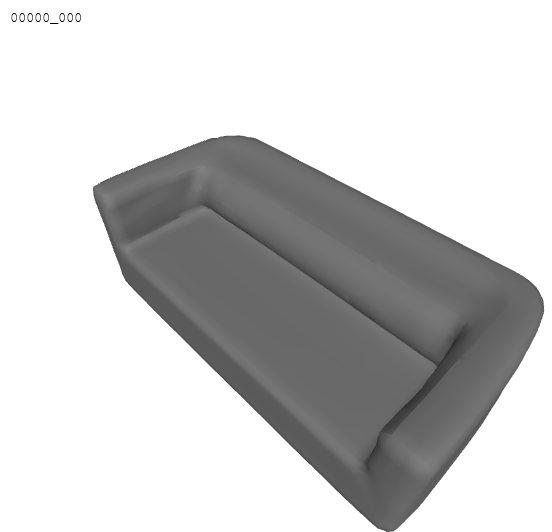

In [26]:
from src.util.mesh_collection_to_gif import  meshes_to_gif
from src.util.misc import show_gif

# create list of meshes (just exported) to be visualized
mesh_paths = sorted([x for x in Path("src/runs/3_2_deepsdf_generalization/interpolation").iterdir() if int(x.name.split('.')[0].split("_")[1]) == 0], key=lambda x: int(x.name.split('.')[0].split("_")[0]))
mesh_paths = mesh_paths + mesh_paths[::-1]

# create a visualization of the interpolation process
meshes_to_gif(mesh_paths, "src/runs/3_2_deepsdf_generalization/latent_interp.gif", 20)
show_gif("src/runs/3_2_deepsdf_generalization/latent_interp.gif")

## References

[1] Dai, Angela, Charles Ruizhongtai Qi, and Matthias Nießner. "Shape completion using 3d-encoder-predictor cnns and shape synthesis." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.

[2] Park, Jeong Joon, et al. "Deepsdf: Learning continuous signed distance functions for shape representation." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019.